# Практика по PyTorch

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
DTYPE = torch.float32

matplotlib.rcParams['figure.figsize'] = (25.0, 10.0)
%matplotlib inline

torch.manual_seed(1)
torch.set_num_threads(12)
print('Threads:', torch.get_num_threads())

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

torch.set_default_device(DEVICE)

print(DEVICE)

Threads: 12
cuda


## Определения

In [3]:
def f(x, y):
    return torch.sin(x + 2 * y) * torch.exp(-torch.pow((2 * x + y), 2))

#def f_(x, y):
#    return torch.sin(y) + torch.cos(x) # for debug and develop

def getRandVector(n):
    v = torch.rand(n, dtype=DTYPE)
    return v * 20.0 - 10.0

## Dataset

In [10]:
n = 20000 # Размер выборки

X = torch.stack((getRandVector(n), getRandVector(n)), dim=1)
y = f(X[:, 0], X[:, 1])
y.unsqueeze_(1)

print(X)
print(y)

tensor([[-1.0922, -0.3862],
        [ 3.8030, -9.8729],
        [ 0.9843, -0.3576],
        ...,
        [-0.3856, -7.3916],
        [ 5.1779, -8.6156],
        [-6.4243, -2.5513]], device='cuda:0')
tensor([[-1.2919e-03],
        [ 1.3647e-03],
        [ 1.9834e-02],
        ...,
        [-5.9322e-30],
        [ 2.3757e-02],
        [ 0.0000e+00]], device='cuda:0')


Text(0.5, 0, 'f(x, y)')

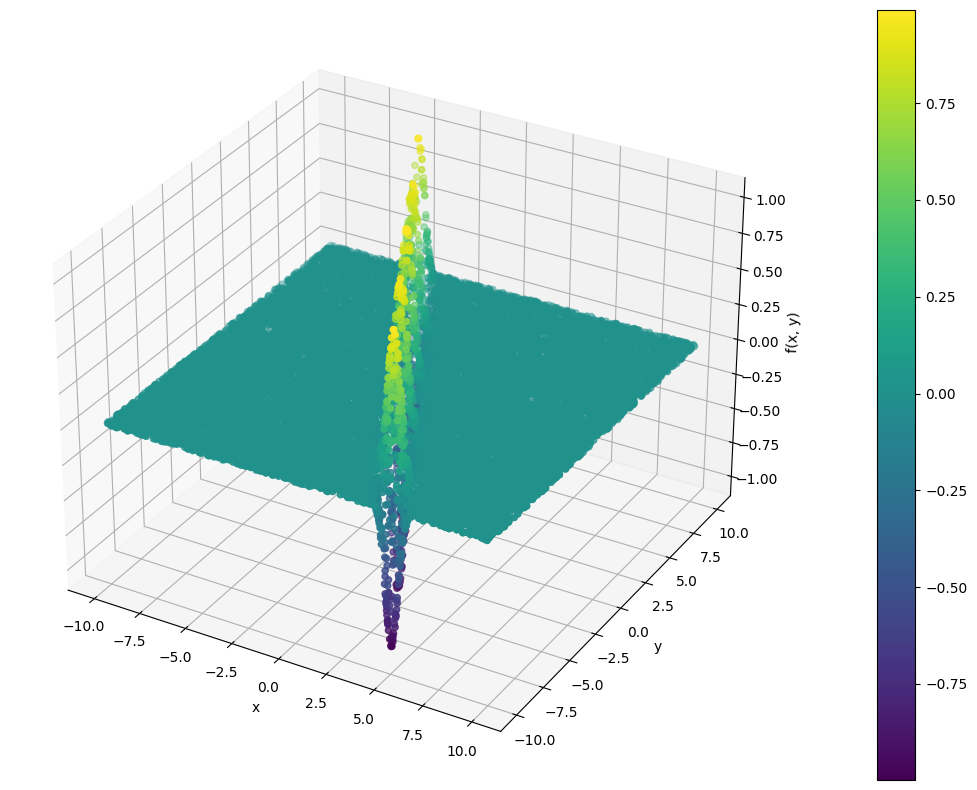

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
dia = ax.scatter(X[:,0].cpu().numpy(), X[:,1].cpu().numpy(), y.cpu().detach().numpy(), c=y.cpu().detach().numpy(), cmap="viridis")
fig.colorbar(dia)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')

## Split dataset to train/test/val
Разделить получившийся датасет на train / test / val в отношениях 70% / 15% / 15%, соответственно.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

#y_train.to('cuda:0')
y_train.device


device(type='cuda', index=0)

## Определяем модель

In [7]:
class RegressionModel(nn.Module):
    def __init__(self, hidden_size, post_size = 200):
        super(RegressionModel, self).__init__()

        self.fc1 = nn.Linear(2, hidden_size, dtype=DTYPE)
        self.act1 = torch.nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, 1, dtype=DTYPE)


    def normalizeInput(self, x):
        # Normalization to range [-1; 1]
        return x / 10


    def forward(self, x):
        x = self.normalizeInput(x)
        x = self.act1(self.fc1(x))
        x = self.fc2(x)
        return x


    def getMetric(model, X_val, y_val):
        y_val_pred = model.forward(X_val)

        mse = loss_MSE(y_val_pred, y_val).detach().numpy()
        #mse = mean_squared_error(y_val_pred.detach().numpy(), y_val.detach().numpy())
        return mse


# если метрика не улучшилась больше чем на level% на протяжении последних 5ти эпох,
# то нейросеть уже дошла до своего предела, так считаем, и останавливаем обучение сети.
# verbose_only — параметр для отладки, когда выводится информация, а реальной остановки не делается
def isStop(mse_list, level=0.005, mseLevel=0.001, verbose_only=False):
    if len(mse_list) >= 5 and mse_list[-1] <= mseLevel:
        n = 4
        events = 0

        if verbose_only:
            print('——————————————')

        for i in range(-n - 1, -1):
                if abs(mse_list[-1] - mse_list[i]) / mse_list[i] < level:
                    if verbose_only:
                        print(mse_list[-1], mse_list[i], abs(mse_list[-1] - mse_list[i]) / mse_list[i])
                    else:
                        events = events + 1

        if events == n:
            return True

    return False


def loss_MSE(pred, target):
    squares = torch.pow(pred - target, 2)
    mse = squares.cpu().mean()
    return mse

## Тренируем модель

 39%|███▉      | 393531/1000000 [15:21<23:40, 426.89it/s]


Обучение нейронной сети завершено.
MSE по валидац. выборке: 0.005


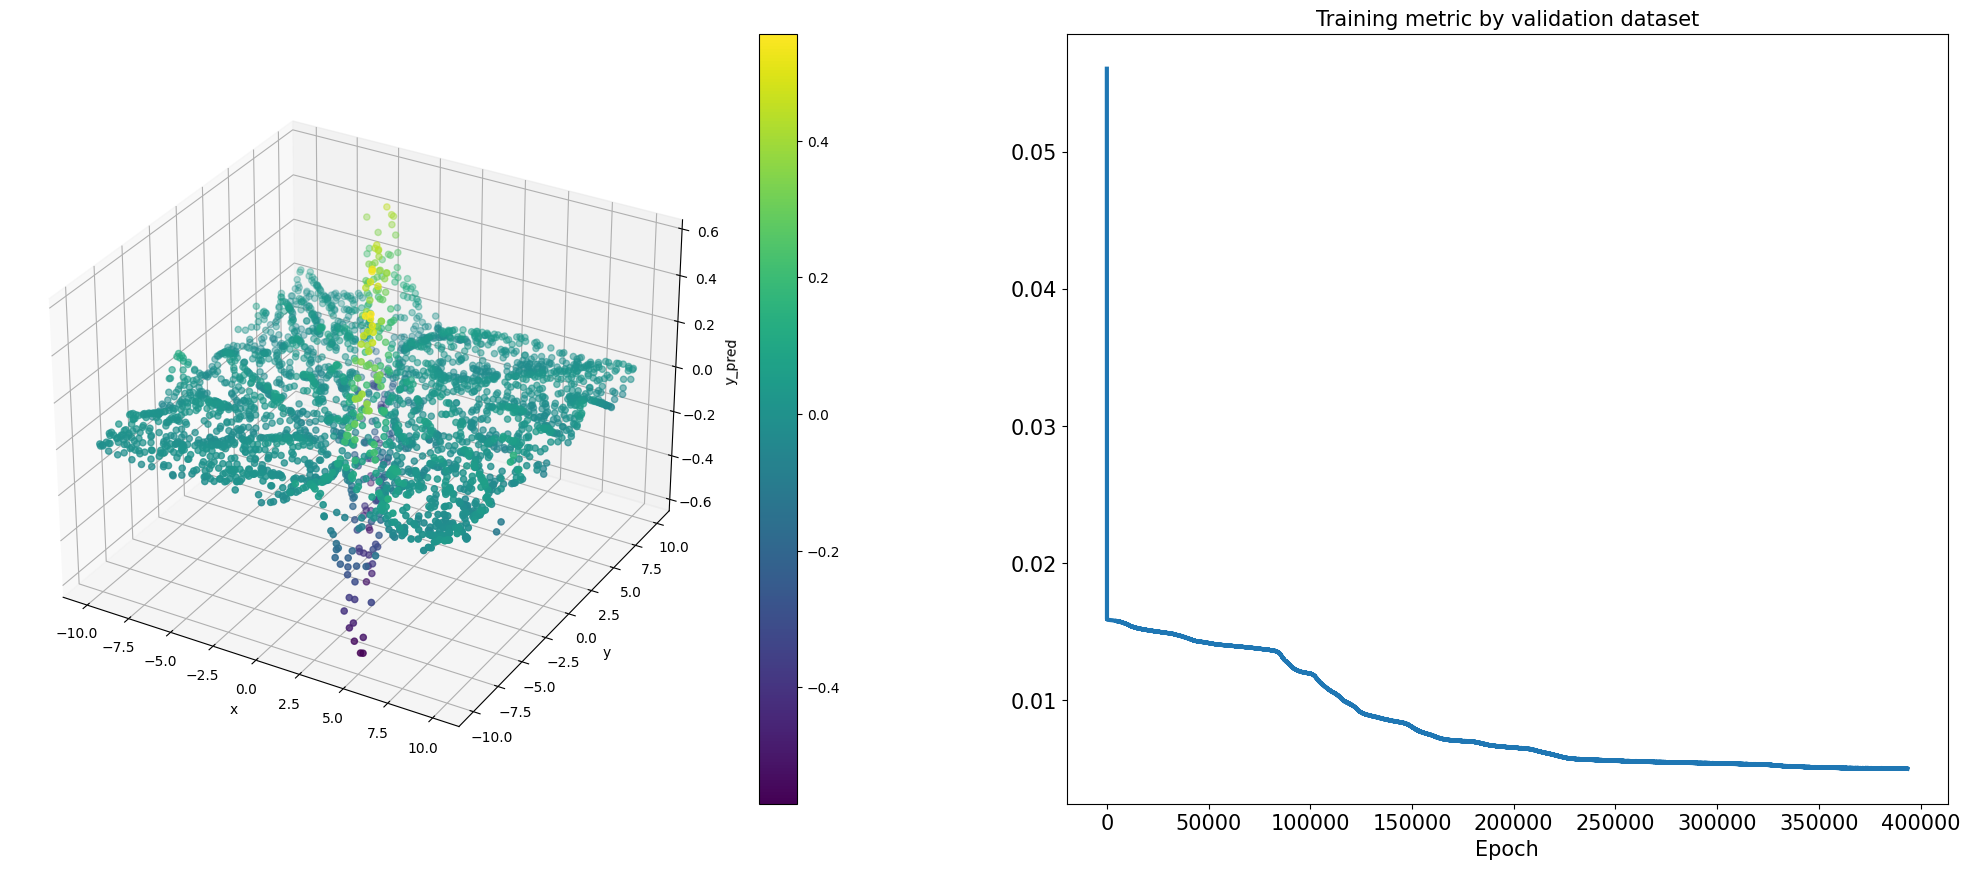

In [13]:
num_epochs = 1000000 # Число эпох
stopLevel = 0.003 # Критерий остановки обучения
mseLevel = 0.005 # Требуемый уровень ошибки MSE

model = RegressionModel(50)
criterion = loss_MSE #nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001) # lr=0.01

mse_list = []
for epoch_index in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

    mse_list.append(model.getMetric(X_val, y_val))

    #if epoch_index % 300 == 0:
    #isStop(mse_list, level=stopLevel, verbose_only=True)

    if isStop(mse_list, level=stopLevel, mseLevel = mseLevel):
        break

print('Обучение нейронной сети завершено.')
print("MSE по валидац. выборке: {:.3f}".format(model.getMetric(X_val, y_val)))

#print(mse_list)

fig = plt.figure()
ax = fig.add_subplot(122)
ax.plot(mse_list, lw=3)
ax.set_title("Training metric by validation dataset", size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

y_pred = model.forward(X_val)

ax = fig.add_subplot(121, projection='3d')
dia = ax.scatter(X_val[:, 0].cpu().numpy(), X_val[:, 1].cpu().numpy(), y_pred.cpu().detach().numpy(), c=y_pred.cpu().detach().numpy(), cmap="viridis")
fig.colorbar(dia)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('y_pred')
plt.show()

## Проверяем результат

RegressionModel(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (act1): Tanh()
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)
MSE по тестовой выборке: 0.005


Text(0.5, 0, 'y_pred')

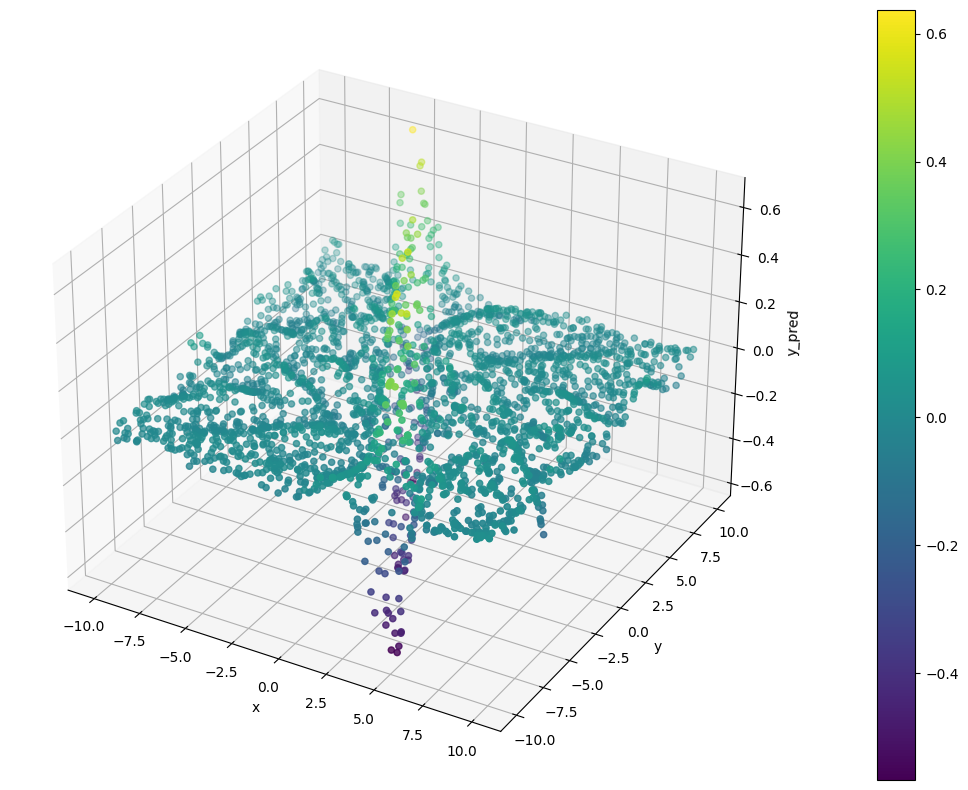

In [14]:

print(model.eval()) # Переводим модель в режим inference

print("MSE по тестовой выборке: {:.3f}".format(model.getMetric(X_test, y_test)))

y_pred = model.forward(X_test)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
dia = ax.scatter(X_test[:, 0].cpu().numpy(), X_test[:, 1].cpu().numpy(), y_pred.cpu().detach().numpy(), c=y_pred.cpu().detach().numpy(), cmap="viridis")
fig.colorbar(dia)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('y_pred')


## График абсолютного значения ошибок

Text(0.5, 0, 'abs(y_pred - y_test)')

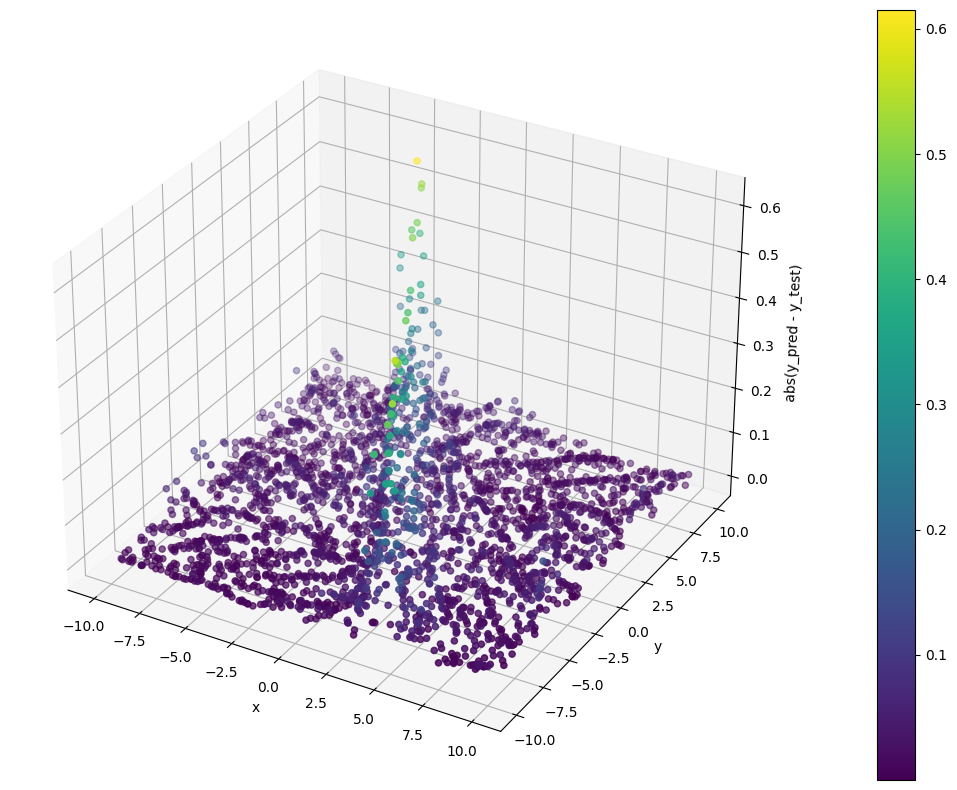

In [16]:
y_error = abs(y_pred - y_test)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
dia = ax.scatter(X_test[:, 0].cpu().numpy(), X_test[:, 1].cpu().numpy(), y_error.cpu().detach().numpy(), c=y_error.cpu().detach().numpy(), cmap="viridis")
fig.colorbar(dia)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('abs(y_pred - y_test)')